In [1]:
import sys
import os

script_path = os.path.abspath('')
current_file_dir = os.path.dirname(script_path)
sys.path.insert(0, f"{current_file_dir}/FinRL/")

import logging
import pandas as pd
import numpy as np
import datetime
import torch
import yfinance as yf

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config_tickers
from finrl.config import INDICATORS

from finrl.meta.preprocessor.preprocessors import GroupByScaler
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv
from finrl.agents.portfolio_optimization.models import DRLAgent
from finrl.agents.portfolio_optimization.architectures import EIIE, EI3, GPM

import src.env as env 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
print(os.getcwd())

/Users/sahiljain/Documents/CS234-Spring 24/cs234-final-project/src


In [3]:
import datetime

In [4]:
len(env.STOCKS)

28

In [5]:
def load_data() -> pd.DataFrame:
    # download data
    stocks = env.STOCKS
    script_path = os.path.abspath('')
    current_file_dir = os.path.dirname(script_path)
    data_path = os.path.join(
           current_file_dir, 
           "src",
           "data", 
           f"{env.TIME_RANGE_START}-{env.TIME_RANGE_START}-{'-'.join(env.STOCKS)}.pkl"
    )
    if not os.path.isfile(data_path): 
       df = YahooDownloader(
               start_date = env.TIME_RANGE_START - datetime.timedelta(days=120),
               end_date = env.TIME_RANGE_END,
               ticker_list = env.STOCKS,
            ).fetch_data()
       df.to_pickle(data_path)
    else:
       df = pd.read_pickle(data_path)
    return df


In [6]:
from finrl.meta.preprocessor.preprocessors import GroupByScaler
from sklearn.preprocessing import MaxAbsScaler

In [7]:
df = load_data()

# preprocess data, calculate set of technical indicators on the data
fe = FeatureEngineer(
       use_technical_indicator=True,
       tech_indicator_list = env.INDICATORS
    )

df = fe.preprocess_data(df)
fmt = "%Y-%m-%d"
train_df = data_split(df, env.TRAIN_START.strftime(fmt), env.TRAIN_END.strftime(fmt))
validation_df = data_split(df, env.VALIDATION_START.strftime(fmt), env.VALIDATION_END.strftime(fmt))
test_df = data_split(df, env.TEST_START.strftime(fmt), env.TEST_END.strftime(fmt))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (72772, 8)
Successfully added technical indicators


In [8]:
train_df.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2010-01-04,7.622500,7.660714,7.585000,6.461977,493729600,AAPL,0,0.116751,6.525679,5.556234,62.199921,168.773574,33.855958,6.045440,5.992479
0,2010-01-04,56.630001,57.869999,56.560001,41.200798,5277400,AMGN,0,0.233768,41.641214,39.135743,52.993920,85.786606,6.332635,40.382053,40.305795
0,2010-01-04,40.810001,41.099998,40.389999,33.090443,6894300,AXP,0,0.279308,34.019874,31.696014,56.582789,1.048475,11.478171,32.976951,31.382809
0,2010-01-04,55.720001,56.389999,54.799999,43.777554,6186700,BA,0,0.490926,44.009591,41.898203,58.953051,81.205432,10.747635,42.319077,40.753000
0,2010-01-04,57.650002,59.189999,57.509998,40.190220,7325600,CAT,0,0.061790,40.590653,38.673664,55.186369,49.405063,8.532797,39.793010,39.412941


In [9]:
features = ["close", "high", "low", "boll_ub", "macd", "boll_lb", "rsi_30", "cci_30", "dx_30"]

In [10]:
def create_graph():
    import yfinance as yf
    from collections import defaultdict
    tickers = " ".join(env.STOCKS)
    tickers = tickers.lower()
    tickers = yf.Tickers(tickers)
    
    ticker_to_info = {}
    
    for ticker in list(env.STOCKS):
        ticker_to_info[ticker] = tickers.tickers[ticker.upper()].info

    from collections import defaultdict
    sector_to_tickers = defaultdict(list)

    edge_from = []
    edge_to = []    

    for ticker, info in ticker_to_info.items():
        sector_to_tickers[info["sector"]].append(ticker)

    for sector, tickers in sector_to_tickers.items():
        for i in range(len(tickers)):
            for j in range(i + 1, len(tickers)):
                tick1 = tickers[i]
                tick2 = tickers[j]
                tick1_index, tick2_index = env.STOCKS.index(tick1), env.STOCKS.index(tick2)
                edge_from.append(tick1_index)
                edge_to.append(tick2_index)
                edge_from.append(tick2_index)
                edge_to.append(tick1_index)

    edge_types = [0] * len(edge_from)
    return torch.tensor([edge_from, edge_to]), torch.tensor(edge_types)

In [48]:
import networkx as nx

In [50]:
edges, _ = create_graph()
G = nx.Graph()

In [53]:
edges = edges.detach().numpy()

In [70]:
edge_to, edge_from = edges
for a, b in zip(edge_to, edge_from):
    G.add_edge(a, b)
    G.add_edge(a, 28)
    G.add_edge(b, 28)

In [63]:
mapping = {env.STOCKS.index(s): s for s in env.STOCKS}

In [71]:
mapping[28] = "DOW"

In [72]:
G = nx.relabel_nodes(G, mapping)

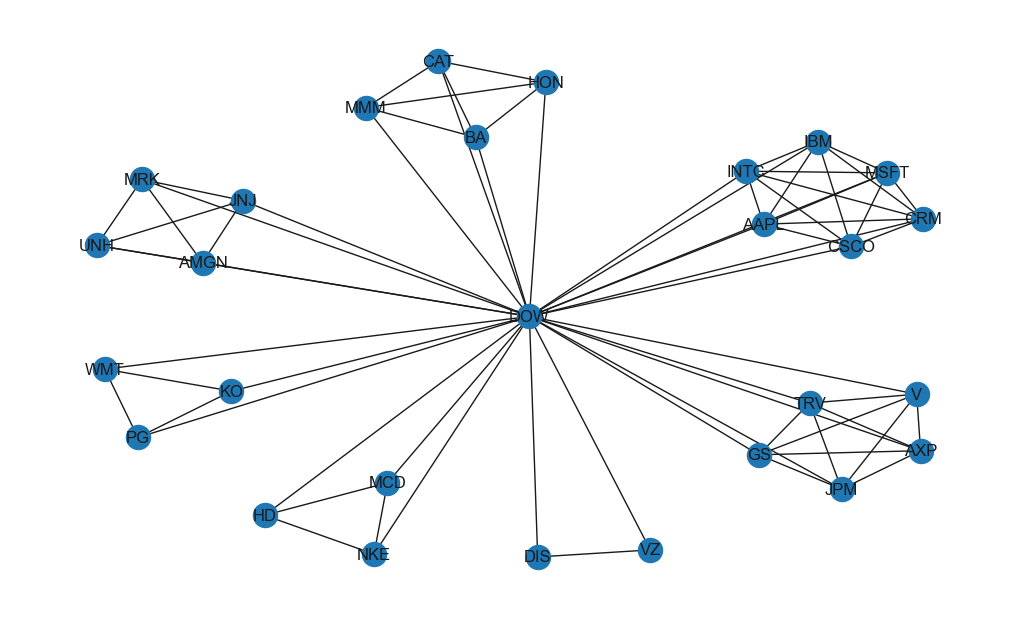

In [73]:
nx.draw(G, with_labels=True)

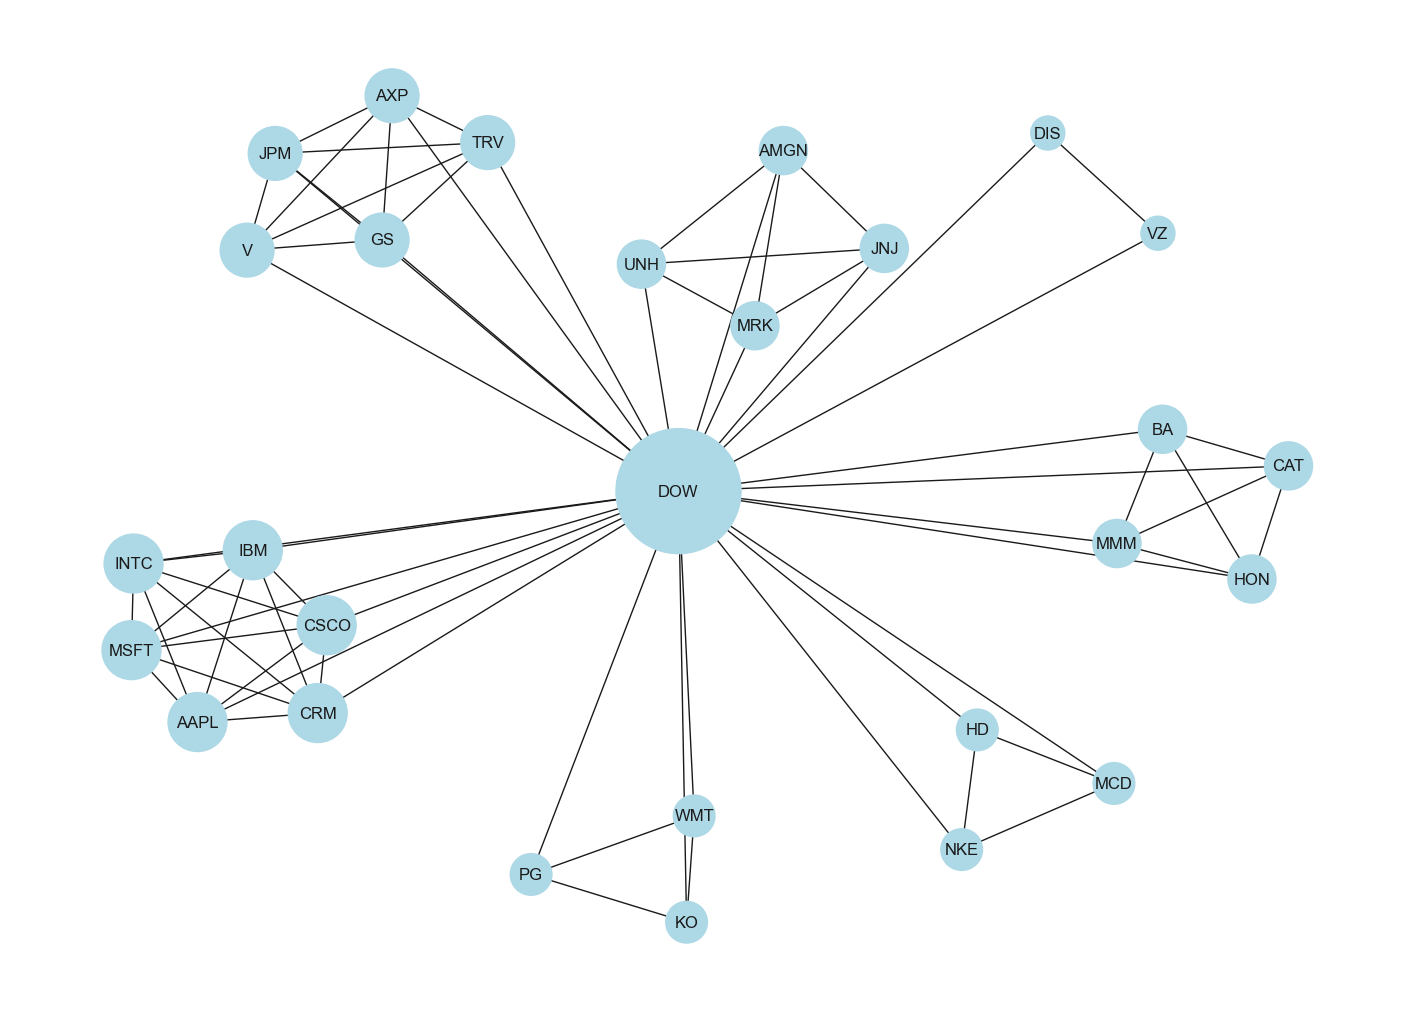

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
pos = nx.spring_layout(G, scale=20, k=3/np.sqrt(G.order()))
d = dict(G.degree)
nx.draw(G, pos, node_color='lightblue', 
        with_labels=True, 
        nodelist=d, 
        node_size=[d[k]*300 for k in d])


In [11]:
import copy

In [12]:
def run_experiment(train_df, validation_df, test_df, model_kwargs, policy_kwargs, algorithm, kwargs):
    results = {
        "train": {},
        "validation": {},
        "test": {},
    }
    environment_train = PortfolioOptimizationEnv(
       train_df,
       **kwargs
    )
    environment_validation = PortfolioOptimizationEnv(
       validation_df,
       **kwargs
    )
    environment_test = PortfolioOptimizationEnv(
        test_df,
        **kwargs
    )

    model_kwargs["validation_env"] = environment_validation
    
    model = DRLAgent(environment_train).get_model(algorithm, device, model_kwargs, policy_kwargs)
    model = DRLAgent.train_model(model, episodes=5)
    DRLAgent.DRL_validation(model, environment_validation, policy=model.train_policy)
    DRLAgent.DRL_validation(model, environment_test, policy=model.train_policy)
    
    results["train"] = environment_train._asset_memory["final"]
    results["validation"] = environment_validation._asset_memory["final"]
    results["test"] = environment_test._asset_memory["final"]
    return results, environment_train, environment_validation, environment_test


In [13]:
"""
Create kwargs
"""
model_kwargs = {
    "lr": env.LR,
}

policy_kwargs = {
    "initial_features": 9,
    "time_window": 50,
}

environment_kwargs = {
    "initial_amount": env.INITIAL_AMT,
    "comission_fee_pct": env.COMISSION_FEE_PCT,
    "time_window": env.TIME_WINDOW,
    "features": features,
    "normalize_df": None
}

In [14]:
policy_to_model_args = {}
policy_to_policy_args = {}

In [15]:
for policy in [EIIE, EI3, GPM]:
    model_kwargs_specific = copy.deepcopy(model_kwargs)
    policy_kwargs_specific = copy.deepcopy(policy_kwargs)
    env_kwargs_specific = copy.deepcopy(environment_kwargs)
    model_kwargs_specific["policy"]=policy
    if policy == GPM:
        model_kwargs_specific["policy"]=policy
        edge_index, edge_type = create_graph()
        policy_kwargs_specific["edge_index"] = edge_index
        policy_kwargs_specific["edge_type"] = edge_type
        policy_kwargs_specific["nodes_to_select"] = list(range(len(env.STOCKS)))
    elif policy == EIIE:
        policy_kwargs_specific["k_size"] = 3
    policy_to_policy_args[policy] = policy_kwargs_specific
    policy_to_model_args[policy] = model_kwargs_specific

In [16]:
config_to_results = {}

In [20]:
for policy in [EI3, EIIE, GPM]:
    results, environment_train, environment_validation, environment_test = run_experiment(
        train_df, validation_df, test_df, policy_to_model_args[policy], policy_to_policy_args[policy], "pg", environment_kwargs
    )
    config_to_results[policy] = (results, environment_train, environment_validation, environment_test)

  0%|                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 101846.640625
Final accumulative portfolio value: 1.01846640625
Maximum DrawDown: -0.36073568752848173
Sharpe ratio: 0.12093403150972554
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 20%|██████████████████████████████████████████                                                                                                                                                                        | 1/5 [00:21<01:25, 21.43s/it]

Initial portfolio value:100000
Final portfolio value: 113771.59375
Final accumulative portfolio value: 1.1377159375
Maximum DrawDown: -0.4757228963463608
Sharpe ratio: 0.18797668412126062
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 2/5 [00:42<01:04, 21.48s/it]

Initial portfolio value:100000
Final portfolio value: 164909.65625
Final accumulative portfolio value: 1.6490965625
Maximum DrawDown: -0.3515112546246797
Sharpe ratio: 0.3997972535168586
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 3/5 [01:04<00:43, 21.58s/it]

Initial portfolio value:100000
Final portfolio value: 231829.34375
Final accumulative portfolio value: 2.3182934375
Maximum DrawDown: -0.30280029694575883
Sharpe ratio: 0.604552551740726
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4/5 [01:26<00:21, 21.60s/it]

Initial portfolio value:100000
Final portfolio value: 236205.296875
Final accumulative portfolio value: 2.36205296875
Maximum DrawDown: -0.33572951632174775
Sharpe ratio: 0.6035228954038828
Initial portfolio value:100000
Final portfolio value: 99081.046875
Final accumulative portfolio value: 0.99081046875
Maximum DrawDown: -0.24667862995903456
Sharpe ratio: 0.11186425093442662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:47<00:00, 21.59s/it]


Initial portfolio value:100000
Final portfolio value: 99081.046875
Final accumulative portfolio value: 0.99081046875
Maximum DrawDown: -0.24667862995903456
Sharpe ratio: 0.11186425093442662
Initial portfolio value:100000
Final portfolio value: 88829.3515625
Final accumulative portfolio value: 0.888293515625
Maximum DrawDown: -0.1808426016618343
Sharpe ratio: -0.39592799046777677


  0%|                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 242155.796875
Final accumulative portfolio value: 2.42155796875
Maximum DrawDown: -0.14909680925320856
Sharpe ratio: 0.9727506435255624
Initial portfolio value:100000
Final portfolio value: 98942.453125
Final accumulative portfolio value: 0.98942453125
Maximum DrawDown: -0.154016295822883
Sharpe ratio: 0.004208658261095723


 20%|██████████████████████████████████████████                                                                                                                                                                        | 1/5 [00:20<01:23, 20.82s/it]

Initial portfolio value:100000
Final portfolio value: 225132.984375
Final accumulative portfolio value: 2.25132984375
Maximum DrawDown: -0.11952096179966176
Sharpe ratio: 0.9928165875038357
Initial portfolio value:100000
Final portfolio value: 100235.9296875
Final accumulative portfolio value: 1.002359296875
Maximum DrawDown: -0.14607738205449128
Sharpe ratio: 0.10150323239884693


 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 2/5 [00:41<01:02, 20.85s/it]

Initial portfolio value:100000
Final portfolio value: 258048.578125
Final accumulative portfolio value: 2.58048578125
Maximum DrawDown: -0.22555958348353045
Sharpe ratio: 0.9512015542699627
Initial portfolio value:100000
Final portfolio value: 125440.3203125
Final accumulative portfolio value: 1.254403203125
Maximum DrawDown: -0.08151335107876834
Sharpe ratio: 1.8332785142959827


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 3/5 [01:02<00:41, 20.93s/it]

Initial portfolio value:100000
Final portfolio value: 331943.15625
Final accumulative portfolio value: 3.3194315625
Maximum DrawDown: -0.1743404223993016
Sharpe ratio: 1.1755102614913875
Initial portfolio value:100000
Final portfolio value: 114698.15625
Final accumulative portfolio value: 1.1469815625
Maximum DrawDown: -0.11001592335816135
Sharpe ratio: 1.127351794259319


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4/5 [01:23<00:20, 20.95s/it]

Initial portfolio value:100000
Final portfolio value: 363753.875
Final accumulative portfolio value: 3.63753875
Maximum DrawDown: -0.14708132912138394
Sharpe ratio: 1.2713793244626144
Initial portfolio value:100000
Final portfolio value: 119843.6640625
Final accumulative portfolio value: 1.198436640625
Maximum DrawDown: -0.08644891177128133
Sharpe ratio: 1.329483789205131


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:44<00:00, 20.96s/it]


Initial portfolio value:100000
Final portfolio value: 119843.6640625
Final accumulative portfolio value: 1.198436640625
Maximum DrawDown: -0.08644891177128133
Sharpe ratio: 1.329483789205131
Initial portfolio value:100000
Final portfolio value: 115691.3125
Final accumulative portfolio value: 1.156913125
Maximum DrawDown: -0.05737013134952962
Sharpe ratio: 1.6522479677115138


  0%|                                                                                                                                                                                                                          | 0/5 [00:00<?, ?it/s]

Initial portfolio value:100000
Final portfolio value: 276132.59375
Final accumulative portfolio value: 2.7613259375
Maximum DrawDown: -0.31361419925296885
Sharpe ratio: 0.7266635316133285
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 20%|██████████████████████████████████████████                                                                                                                                                                        | 1/5 [00:22<01:30, 22.52s/it]

Initial portfolio value:100000
Final portfolio value: 78113.5625
Final accumulative portfolio value: 0.781135625
Maximum DrawDown: -0.47962740231626366
Sharpe ratio: -0.029877148989004766
Initial portfolio value:100000
Final portfolio value: 99077.828125
Final accumulative portfolio value: 0.99077828125
Maximum DrawDown: -0.24670318084390186
Sharpe ratio: 0.11173165820516144


 40%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                              | 2/5 [00:45<01:07, 22.61s/it]

Initial portfolio value:100000
Final portfolio value: 95048.96875
Final accumulative portfolio value: 0.9504896875
Maximum DrawDown: -0.5003081309807147
Sharpe ratio: 0.07998013421272586
Initial portfolio value:100000
Final portfolio value: 85393.75
Final accumulative portfolio value: 0.8539375
Maximum DrawDown: -0.2887054990575769
Sharpe ratio: -0.5700620417070108


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 3/5 [01:07<00:45, 22.62s/it]

Initial portfolio value:100000
Final portfolio value: 300094.34375
Final accumulative portfolio value: 3.0009434375
Maximum DrawDown: -0.4694361106269822
Sharpe ratio: 0.7173674837884721
Initial portfolio value:100000
Final portfolio value: 89855.7109375
Final accumulative portfolio value: 0.898557109375
Maximum DrawDown: -0.23135805089217754
Sharpe ratio: -0.3708501028755216


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 4/5 [01:30<00:22, 22.64s/it]

Initial portfolio value:100000
Final portfolio value: 593483.1875
Final accumulative portfolio value: 5.934831875
Maximum DrawDown: -0.35337581681944885
Sharpe ratio: 1.0689707307146226
Initial portfolio value:100000
Final portfolio value: 99104.578125
Final accumulative portfolio value: 0.99104578125
Maximum DrawDown: -0.24670324086398643
Sharpe ratio: 0.09259591718182486


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:53<00:00, 22.66s/it]


Initial portfolio value:100000
Final portfolio value: 99104.578125
Final accumulative portfolio value: 0.99104578125
Maximum DrawDown: -0.24670324086398643
Sharpe ratio: 0.09259591718182486
Initial portfolio value:100000
Final portfolio value: 133461.640625
Final accumulative portfolio value: 1.33461640625
Maximum DrawDown: -0.1808426016618343
Sharpe ratio: 1.4931510458041253


In [32]:
config_to_results.keys()

dict_keys([<class 'finrl.agents.portfolio_optimization.architectures.EI3'>, <class 'finrl.agents.portfolio_optimization.architectures.EIIE'>, <class 'finrl.agents.portfolio_optimization.architectures.GPM'>])

In [28]:

# environment = PortfolioOptimizationEnv(
#     train_df,
#     initial_amount=100000,
#     comission_fee_pct=0.0025,
#     time_window=50,
#     features=["close", "high", "low"],
#     normalize_df=None
# )

# UBAH_results = {
#     "train": {},
#     "validation": {},
#     "test": {},
# }

# PORTFOLIO_SIZE = len(env.STOCKS)

# # train period
# terminated = False
# environment_train.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     print(action)
#     _, _, terminated, _ = environment_train.step(action)
# UBAH_results["train"] = environment_train._asset_memory["final"]

# # validation period
# terminated = False
# environment_validation.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_validation.step(action)
# UBAH_results["validation"] = environment_validation._asset_memory["final"]

# # test period
# terminated = False
# environment_test.reset()
# while not terminated:
#     action = [0] + [1/PORTFOLIO_SIZE] * PORTFOLIO_SIZE
#     _, _, terminated, _ = environment_test.step(action)
# UBAH_results["test"] = environment_test._asset_memory["final"]


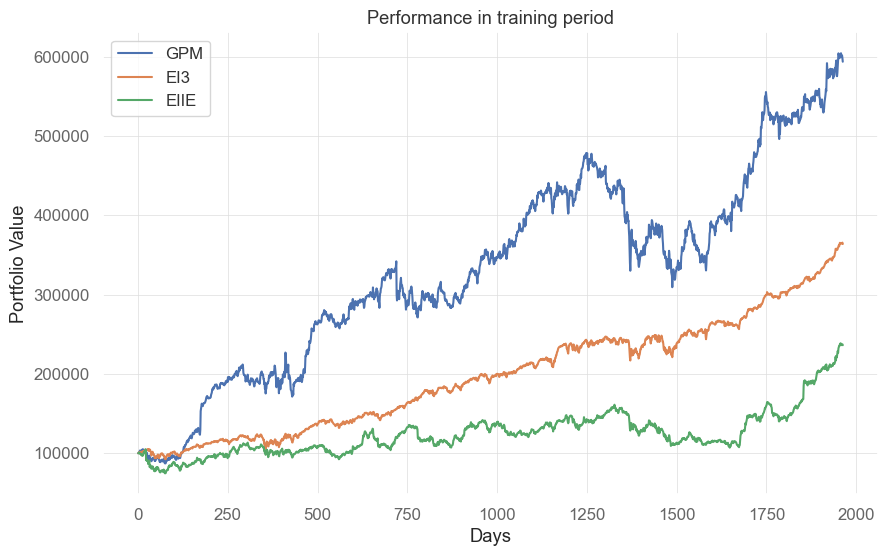

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["train"], label="GPM")
plt.plot(config_to_results[EIIE][0]["train"], label="EI3")
plt.plot(config_to_results[EI3][0]["train"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()


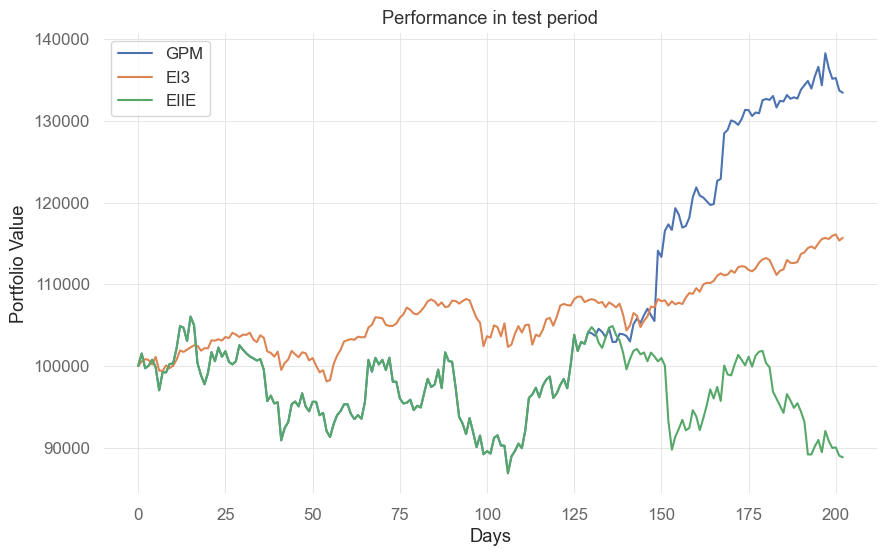

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["test"], label="GPM")
plt.plot(config_to_results[EIIE][0]["test"], label="EI3")
plt.plot(config_to_results[EI3][0]["test"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in test period")
plt.legend()

plt.show()


In [44]:
len(config_to_results[GPM][0]["test"])

203

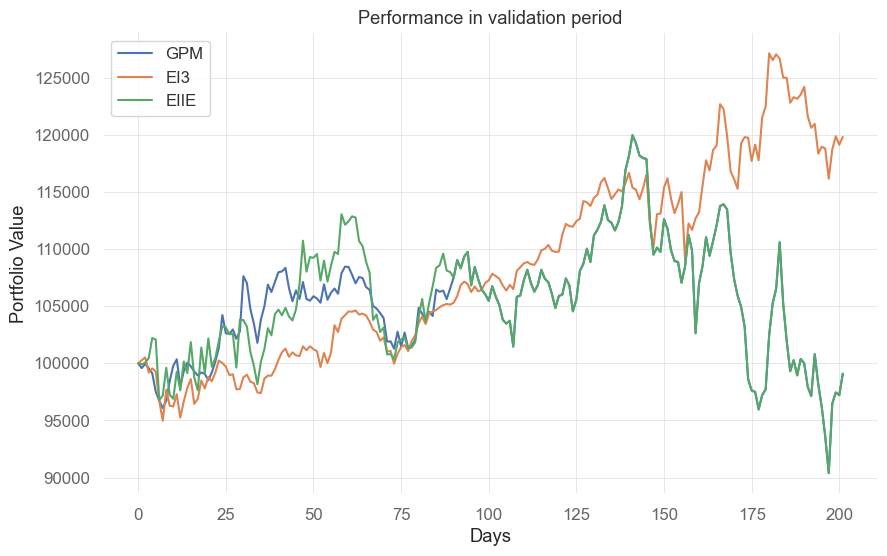

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.plot(UBAH_results["train"], label="Buy and Hold")
plt.plot(config_to_results[GPM][0]["validation"], label="GPM")
plt.plot(config_to_results[EIIE][0]["validation"], label="EI3")
plt.plot(config_to_results[EI3][0]["validation"], label="EIIE")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in validation period")
plt.legend()

plt.show()
